In [2]:
import tensorflow as tf

In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [7]:
x_train[0].shape

(28, 28)

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2959 - accuracy: 0.9139
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1412 - accuracy: 0.9588
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1077 - accuracy: 0.9678
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0851 - accuracy: 0.9731
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0755 - accuracy: 0.9772


In [11]:
model.evaluate(x_test,  y_test, verbose=2)


313/313 - 0s - loss: 0.0750 - accuracy: 0.9773


[0.07500936836004257, 0.9772999882698059]

In [12]:
import functools

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [13]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)



16384/13049 [=====================================] - 0s 0us/step


In [14]:
np.set_printoptions(precision=3, suppress=True)

In [16]:
LABEL_COLUMN = 'survived'
LABELS = [0, 1]

In [18]:
def get_dataset(file_path):
  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=12, # 为了示例更容易展示，手动设置较小的值
      label_name=LABEL_COLUMN,
      na_value="?",
      num_epochs=1,
      ignore_errors=True)
  return dataset

raw_train_data = get_dataset(train_file_path)
raw_test_data = get_dataset(test_file_path)

In [19]:
examples, labels = next(iter(raw_train_data)) # 第一个批次
print("EXAMPLES: \n", examples, "\n")
print("LABELS: \n", labels)

EXAMPLES: 
 OrderedDict([('sex', <tf.Tensor: shape=(12,), dtype=string, numpy=
array([b'male', b'male', b'female', b'female', b'female', b'male',
       b'female', b'female', b'male', b'male', b'male', b'female'],
      dtype=object)>), ('age', <tf.Tensor: shape=(12,), dtype=float32, numpy=
array([28., 33., 27., 32.,  2., 64., 14.,  9., 28., 21.,  4., 44.],
      dtype=float32)>), ('n_siblings_spouses', <tf.Tensor: shape=(12,), dtype=int32, numpy=array([0, 0, 0, 0, 1, 1, 0, 3, 0, 0, 4, 0], dtype=int32)>), ('parch', <tf.Tensor: shape=(12,), dtype=int32, numpy=array([0, 0, 2, 0, 1, 4, 0, 2, 0, 0, 2, 1], dtype=int32)>), ('fare', <tf.Tensor: shape=(12,), dtype=float32, numpy=
array([  7.75 ,   8.654,  11.133,  13.   ,  26.   , 263.   ,   7.854,
        27.9  ,  31.   ,   8.433,  31.275,  57.979], dtype=float32)>), ('class', <tf.Tensor: shape=(12,), dtype=string, numpy=
array([b'Third', b'Third', b'Third', b'Second', b'Second', b'First',
       b'Third', b'Third', b'First', b'Third', b'Thir

In [20]:
CATEGORIES = {
    'sex': ['male', 'female'],
    'class' : ['First', 'Second', 'Third'],
    'deck' : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'embark_town' : ['Cherbourg', 'Southhampton', 'Queenstown'],
    'alone' : ['y', 'n']
}

In [21]:
categorical_columns = []
for feature, vocab in CATEGORIES.items():
  cat_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab)
  categorical_columns.append(tf.feature_column.indicator_column(cat_col))

In [22]:
type(categorical_columns[0])

tensorflow.python.feature_column.feature_column_v2.IndicatorColumn

In [23]:
def process_continuous_data(mean, data):
  # 标准化数据
  data = tf.cast(data, tf.float32) * 1/(2*mean)
  return tf.reshape(data, [-1, 1])

In [24]:
MEANS = {
    'age' : 29.631308,
    'n_siblings_spouses' : 0.545455,
    'parch' : 0.379585,
    'fare' : 34.385399
}

numerical_columns = []

for feature in MEANS.keys():
  num_col = tf.feature_column.numeric_column(feature, normalizer_fn=functools.partial(process_continuous_data, MEANS[feature]))
  numerical_columns.append(num_col)

In [25]:
numerical_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function process_continuous_data at 0x7ff61c466510>, 29.631308)),
 NumericColumn(key='n_siblings_spouses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function process_continuous_data at 0x7ff61c466510>, 0.545455)),
 NumericColumn(key='parch', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function process_continuous_data at 0x7ff61c466510>, 0.379585)),
 NumericColumn(key='fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function process_continuous_data at 0x7ff61c466510>, 34.385399))]

In [26]:
preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_columns+numerical_columns)

In [27]:
model = tf.keras.Sequential([
  preprocessing_layer,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [28]:
train_data = raw_train_data.shuffle(500)
test_data = raw_test_data

In [29]:
model.fit(train_data, epochs=20)

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
53/53 [==============================] - 0s 2ms/step - loss: 0.5596 - accuracy: 0.7448
Epoch 2/20
53/53 [==============================] - 0s 1ms/step - loss: 0.4483 - accuracy: 0.8070
Epoch 3/20
53/53 [==============================] - 0s 1ms/step - loss: 0.4375 - accuracy: 0.8086
Epoch 4/20
53/53 [==============================] - 0s 1ms/step - loss: 0.4125 - accuracy: 0.8293
Epoch 5/20
53/53 [==============================] - 0s 1ms/step - loss: 0.4071 - accuracy: 0.8198
Epoch 6/20
53/53 [==============================] - 0s 1ms/step - loss: 0.4024 - accuracy: 0.8293
Epoch 7/20
53/53 [==============================] - 0s 1ms/step - loss: 0.3874 - accuracy: 0.8341
Epoch 8/20
53/53 [==============================] - 0s 1ms/step - loss: 0.3861 - accuracy: 0.8325
Epoch 9/20
53/53 [==============================] - 0s 1ms/step - loss: 0.3748 - accuracy: 0.8325
Epoch 10

In [30]:
test_loss, test_accuracy = model.evaluate(test_data)

print('\n\nTest Loss {}, Test Accuracy {}'.format(test_loss, test_accuracy))

Consider rewriting this model with the Functional API.
22/22 [==============================] - 0s 1ms/step - loss: 0.4354 - accuracy: 0.8295


Test Loss 0.4353879690170288, Test Accuracy 0.8295454382896423


In [31]:
predictions = model.predict(test_data)

# 显示部分结果
for prediction, survived in zip(predictions[:10], list(test_data)[0][1][:10]):
  print("Predicted survival: {:.2%}".format(prediction[0]),
        " | Actual outcome: ",
        ("SURVIVED" if bool(survived) else "DIED"))

Consider rewriting this model with the Functional API.
Predicted survival: 6.11%  | Actual outcome:  DIED
Predicted survival: 7.53%  | Actual outcome:  SURVIVED
Predicted survival: 34.53%  | Actual outcome:  SURVIVED
Predicted survival: 17.09%  | Actual outcome:  DIED
Predicted survival: 27.22%  | Actual outcome:  DIED
Predicted survival: 55.60%  | Actual outcome:  SURVIVED
Predicted survival: 5.39%  | Actual outcome:  DIED
Predicted survival: 7.38%  | Actual outcome:  DIED
Predicted survival: 10.85%  | Actual outcome:  DIED
Predicted survival: 54.94%  | Actual outcome:  SURVIVED


### question about tensorflow

In [ ]:
# tensorflow 如何利用gpu加速计算  如何在cpu和gpu之间计算梯度

### from simple tensorflow // tf.wiki

In [4]:
import tensorflow as tf

In [10]:
import numpy as np

In [13]:
import pdb

In [5]:
class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()
        # MNIST中的图像默认为uint8（0-255的数字）。以下代码将其归一化到0-1之间的浮点数，并在最后增加一维作为颜色通道
        self.train_data = np.expand_dims(self.train_data.astype(np.float32) / 255.0, axis=-1)      # [60000, 28, 28, 1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32) / 255.0, axis=-1)        # [10000, 28, 28, 1]
        self.train_label = self.train_label.astype(np.int32)    # [60000]
        self.test_label = self.test_label.astype(np.int32)      # [10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):
        # 从数据集中随机取出batch_size个元素并返回
        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]

In [6]:
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()    # Flatten层将除第一维（batch_size）以外的维度展平
        self.dense1 = tf.keras.layers.Dense(units=100, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)

    def call(self, inputs):         # [batch_size, 28, 28, 1]
        x = self.flatten(inputs)    # [batch_size, 784]
        x = self.dense1(x)          # [batch_size, 100]
        x = self.dense2(x)          # [batch_size, 10]
        output = tf.nn.softmax(x)
        return output

In [7]:
num_epochs = 5
batch_size = 50
learning_rate = 0.001


In [11]:
model = MLP()
data_loader = MNISTLoader()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [14]:
num_batches = int(data_loader.num_train_data // batch_size * num_epochs)
for batch_index in range(num_batches):
    pdb.set_trace()
    X, y = data_loader.get_batch(batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch %d: loss %f" % (batch_index, loss.numpy()))
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))

> <ipython-input-14-fe9ac746167e>(4)<module>()
      2 for batch_index in range(num_batches):
      3     pdb.set_trace()
----> 4     X, y = data_loader.get_batch(batch_size)
      5     with tf.GradientTape() as tape:
      6         y_pred = model(X)

ipdb> n
> <ipython-input-14-fe9ac746167e>(5)<module>()
      3     pdb.set_trace()
      4     X, y = data_loader.get_batch(batch_size)
----> 5     with tf.GradientTape() as tape:
      6         y_pred = model(X)
      7         loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)

ipdb> type(X)
<class 'numpy.ndarray'>
ipdb> X.shape
(50, 28, 28, 1)
ipdb> q


BdbQuit: 

# tensorflow api learn

In [47]:
#查看版本号
tf.__version__

'2.2.3'

In [3]:
t=[[[1,1,1],[2,2,2]],[[3,3,3],[4,4,4]],[[5,5,5],[6,6,6]]]
s1=tf.slice(t,[1,0,0],[1,1,3])

In [10]:
t

[[[1, 1, 1], [2, 2, 2]], [[3, 3, 3], [4, 4, 4]], [[5, 5, 5], [6, 6, 6]]]

In [12]:
t1 = tf.constant([0, 1, 2, 3, 4, 5, 6, 7])

In [13]:
print(tf.slice(t1,
               begin=[1],
               size=[3]))

tf.Tensor([1 2 3], shape=(3,), dtype=int32)


In [27]:
# loss

In [36]:
y_true = [[0, 1], [0, 0]]
y_pred = [[-18.6, 0.51], [2.94, -12.8]]

In [37]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
bce1 = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [40]:
x = bce(y_true, y_pred)
x1 = bce1(y_true,y_pred)

In [41]:
x

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.23515666, 1.4957594 ], dtype=float32)>

In [42]:
x1

<tf.Tensor: shape=(), dtype=float32, numpy=0.865458>

In [46]:
x2 = tf.nn.compute_average_loss(x,global_batch_size=2)
x2

<tf.Tensor: shape=(), dtype=float32, numpy=0.865458>

## model save

In [104]:
import os
from tensorflow.keras import Model #与tensorflow.python.keras
from tensorflow import keras

In [105]:
# 用keras.Model 则不需要用 @tf.function
class CustomModule(Model):

  def __init__(self):
    super(CustomModule, self).__init__()
    self.v = tf.Variable(1.)

  def call(self, x):
    print('Tracing with', x)
    return x * self.v

  @tf.function(input_signature=[tf.TensorSpec([], tf.float32)])
  def mutate(self, new_v):
    self.v.assign(new_v)

module = CustomModule()

module_no_signatures_path = os.path.join('./', 'module_no_signatures_model_nopython')

print(module(tf.constant(0.)) )

tf.saved_model.save(module, module_no_signatures_path) 

imported = tf.saved_model.load(module_no_signatures_path)

print(imported(tf.constant(3.)) )

print(imported.mutate(tf.constant(2.)) )

print(imported(tf.constant(3.)) )

Tracing with tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
Tracing with Tensor("input_1:0", shape=(), dtype=float32)
Tracing with Tensor("input_1:0", shape=(), dtype=float32)
INFO:tensorflow:Assets written to: ./module_no_signatures_model_nopython/assets
tf.Tensor(3.0, shape=(), dtype=float32)
None
tf.Tensor(6.0, shape=(), dtype=float32)


In [88]:
# 使用tf.Module则需要 @tf.function
class CustomModule(tf.Module):

  def __init__(self):
    super(CustomModule, self).__init__()
    self.v = tf.Variable(1.)

  @tf.function  # ruguo 这里删除@tf.function则29行报错
  def __call__(self, x):
    print('Tracing with', x)
    return x * self.v

  @tf.function(input_signature=[tf.TensorSpec([], tf.float32)])
  def mutate(self, new_v):
    self.v.assign(new_v)

module = CustomModule()

module_no_signatures_path = os.path.join('./', 'module_no_signatures_module_temp')

print(module(tf.constant(0.)) )

tf.saved_model.save(module, module_no_signatures_path) 

imported = tf.saved_model.load(module_no_signatures_path)

print(imported.mutate(tf.constant(2.0)) )

print(imported(tf.constant(3.)) )

Tracing with Tensor("x:0", shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
Tracing with Tensor("x:0", shape=(), dtype=float32)
INFO:tensorflow:Assets written to: ./module_no_signatures_module_temp/assets
None
tf.Tensor(6.0, shape=(), dtype=float32)


In [90]:
# keras 保存方式
class CustomModule(Model):

  def __init__(self):
    super(CustomModule, self).__init__()
    self.v = tf.Variable(1.)

  def call(self, x):
    print('Tracing with', x)
    return x * self.v

  @tf.function(input_signature=[tf.TensorSpec([], tf.float32)])
  def mutate(self, new_v):
    self.v.assign(new_v)

module = CustomModule()

module_no_signatures_path = os.path.join('./', 'module_no_signatures_model_keras')

print(module(tf.constant(0.)) )

module.save(module_no_signatures_path)


imported = keras.models.load_model(module_no_signatures_path)

print(imported.mutate(tf.constant(2.0)) )

print(imported(tf.constant(3.)) )

Tracing with tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
Tracing with Tensor("input_1:0", shape=(), dtype=float32)
Tracing with Tensor("input_1:0", shape=(), dtype=float32)
INFO:tensorflow:Assets written to: ./module_no_signatures_model_keras/assets


In [94]:
# check-point
# 设置断点
checkpoint = tf.train.Checkpoint(module=module)
manager = tf.train.CheckpointManager(
    checkpoint, directory="./module_no_signatures_model_checkpoint", max_to_keep=2)


# 保存断点
manager.save()

manager.save()

manager.save()

module.mutate(5.0)

print(module(1.0))

# 加载最新的断点，会去更新checkpoint里面的参数
status = checkpoint.restore(manager.latest_checkpoint)

print(module(1.0))

# 访问ckpt成员
checkpoint.step

# todo check if iterator can be restored by checkpoint.restore()

In [180]:
#iterator can be saved as follows
data = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
label = np.array([0, 0, 1, 0, 1, 1, 0, 1, 0, 0])
dataset = tf.data.Dataset.from_tensor_slices((data, label))
it = iter(dataset)
checkpoint = tf.train.Checkpoint(iterator=it)
manager = tf.train.CheckpointManager(
    checkpoint, directory="./module_no_signatures_iterator", max_to_keep=1)


step = 0
for i in it:
    if step >5:
        break
    step +=1
    print(i)

print('---------------')
manager.save()

for i in it:
    print(i)

print('-------------')
for i in it:
    print(i)
print('---------------')
print('restored')
status = checkpoint.restore(manager.latest_checkpoint)
for i in it:
    print(i)

(<tf.Tensor: shape=(), dtype=float64, numpy=0.1>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=float64, numpy=0.2>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=float64, numpy=0.3>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=float64, numpy=0.4>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=float64, numpy=0.5>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=float64, numpy=0.6>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
---------------
(<tf.Tensor: shape=(), dtype=float64, numpy=0.8>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=float64, numpy=0.9>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=float64, numpy=1.0>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
-------------
---------------
restored
(<tf.Tensor: shape=(), dtype=float64, numpy=0.8>, <tf.Tensor: shape=(), dtype=int64, numpy

## dataset

In [106]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")

7905280/7904079 [==============================] - 0s 0us/step


In [107]:
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [108]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

parsed.features.feature['image/text']

bytes_list {
  value: "Rue Perreyon"
}

In [113]:
type(parsed.features.feature)

google.protobuf.pyext._message.MessageMapContainer

In [119]:
filenames = [["/var/data/file1.txt", "/var/data/file2.txt",
             "/var/data/file3.txt", "/var/data/file4.txt"],
             ["/var/data/file1.txt", "/var/data/file2.txt",
             "/var/data/file3.txt", "/var/data/file4.txt"],
             ["/var/data/file1.txt", "/var/data/file2.txt",
             "/var/data/file3.txt", "/var/data/file4.txt"],
             ["/var/data/file1.txt", "/var/data/file2.txt",
             "/var/data/file3.txt", "/var/data/file4.txt"]
            ]
dataset = tf.data.Dataset.from_tensor_slices(filenames)

In [120]:
dataset

<TensorSliceDataset shapes: (4,), types: tf.string>

In [121]:
for i in dataset:
    print(i)

tf.Tensor(
[b'/var/data/file1.txt' b'/var/data/file2.txt' b'/var/data/file3.txt'
 b'/var/data/file4.txt'], shape=(4,), dtype=string)
tf.Tensor(
[b'/var/data/file1.txt' b'/var/data/file2.txt' b'/var/data/file3.txt'
 b'/var/data/file4.txt'], shape=(4,), dtype=string)
tf.Tensor(
[b'/var/data/file1.txt' b'/var/data/file2.txt' b'/var/data/file3.txt'
 b'/var/data/file4.txt'], shape=(4,), dtype=string)
tf.Tensor(
[b'/var/data/file1.txt' b'/var/data/file2.txt' b'/var/data/file3.txt'
 b'/var/data/file4.txt'], shape=(4,), dtype=string)


### example of reading and writing a picture to a file

In [122]:
# get file
cat_in_snow  = tf.keras.utils.get_file('320px-Felis_catus-cat_on_snow.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')
williamsburg_bridge = tf.keras.utils.get_file('194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg')

16384/15477 [===============================] - 0s 0us/step


In [123]:
import IPython.display as display

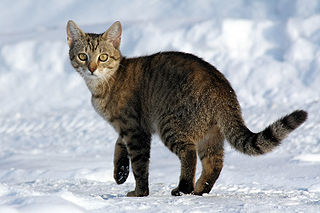

In [124]:
display.display(display.Image(filename=cat_in_snow))
display.display(display.HTML('Image cc-by: &lt;a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg"&gt;Von.grzanka&lt;/a&gt;'))

In [126]:
cat_in_snow

'/home/jovyan/.keras/datasets/320px-Felis_catus-cat_on_snow.jpg'

In [129]:
# ready to write images to a file with tfrecord format

# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [130]:
# write image to tfrecord
image_string = open(cat_in_snow, 'rb').read()
label = 1

def image_example(image_string, label):
  image_shape = tf.image.decode_jpeg(image_string).shape
  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

ie = image_example(image_string,label)

In [133]:
ie.features

feature {
  key: "depth"
  value {
    int64_list {
      value: 3
    }
  }
}
feature {
  key: "height"
  value {
    int64_list {
      value: 213
    }
  }
}
feature {
  key: "image_raw"
  value {
    bytes_list {
      value: "\377\330\377\340\000\020JFIF\000\001\001\001\000H\000H\000\000\377\333\000C\000\006\004\005\006\005\004\006\006\005\006\007\007\006\010\n\020\n\n\t\t\n\024\016\017\014\020\027\024\030\030\027\024\026\026\032\035%\037\032\033#\034\026\026 , #&\')*)\031\037-0-(0%()(\377\333\000C\001\007\007\007\n\010\n\023\n\n\023(\032\026\032((((((((((((((((((((((((((((((((((((((((((((((((((\377\300\000\021\010\000\325\001@\003\001\021\000\002\021\001\003\021\001\377\304\000\034\000\000\002\002\003\001\001\000\000\000\000\000\000\000\000\000\000\003\004\002\005\001\006\007\010\000\377\304\000?\020\000\002\001\003\003\002\005\001\005\006\005\002\006\003\000\000\001\002\003\000\004\021\005\022!1A\006\023\"Qaq\007\0242\201\221\010#B\241\261\360\025R\301\321\361b\341\026$3Cr\2024S

In [134]:
record_file = './images.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
    writer.write(ie.SerializeToString())

In [135]:
# read image from the file above
raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')

image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

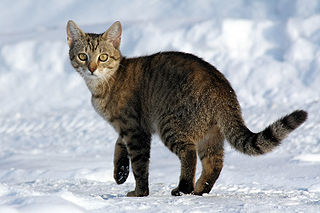

In [136]:
for image_features in parsed_image_dataset:
  image_raw = image_features['image_raw'].numpy()
  display.display(display.Image(data=image_raw))

### read and watch search rank tfrecord data

In [139]:
filepath= '/hdfs/user/ld-jiahua_wu/sq-rank-service/enc/combination_unified_v2_2/train/list_tfdata/ID/20210712/data.tfd.0115899577788536205463366997816311623391'

rankData = tf.data.TFRecordDataset(filepath)

In [140]:
print(rankData.element_spec)

TensorSpec(shape=(), dtype=tf.string, name=None)


In [147]:
for raw_record in rankData.take(1):  # 从dataset中取一个样本进行查看即可
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "i"
    value {
      int64_list {
        value: 0
        value: 1
        value: 3
        value: 4
        value: 5
        value: 6
        value: 7
        value: 8
        value: 9
        value: 10
        value: 11
        value: 12
        value: 16
        value: 17
        value: 19
        value: 20
        value: 22
        value: 23
        value: 25
        value: 26
        value: 28
        value: 29
        value: 31
        value: 32
        value: 34
        value: 35
        value: 37
        value: 38
        value: 40
        value: 41
        value: 43
        value: 44
        value: 46
        value: 47
        value: 49
        value: 50
        value: 52
        value: 53
        value: 55
        value: 56
        value: 58
        value: 59
        value: 61
        value: 62
        value: 64
        value: 65
        value: 67
        value: 68
        value: 70
        value: 71
        value: 73
        value: 74
      

In [154]:
description = {
    'i': tf.io.FixedLenFeature(
        [554], #要确定维度 不然会报错
        tf.int64,
    ),
    'l': tf.io.FixedLenFeature(
        [2],
        tf.int64,
    ),
    'v': tf.io.FixedLenFeature(
        [554],
        tf.float32,
    ),
}


def _parse_example(example):
    return tf.io.parse_single_example(example, description)

rankData = tf.data.TFRecordDataset(filepath)
rankDataMap = rankData.map(_parse_example)

for item in rankDataMap:
    print(item)
    break


{'i': <tf.Tensor: shape=(554,), dtype=int64, numpy=
array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  16,
        17,  19,  20,  22,  23,  25,  26,  28,  29,  31,  32,  34,  35,
        37,  38,  40,  41,  43,  44,  46,  47,  49,  50,  52,  53,  55,
        56,  58,  59,  61,  62,  64,  65,  67,  68,  70,  71,  73,  74,
        76,  77,  79,  80,  82,  83,  85,  86,  88,  89,  91,  92,  94,
        95,  97,  98, 100, 101, 103, 104, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 

### parse tfrecord

In [ ]:
# for a single example use  "tf.io.parse_single_example(serialized_example, features=description)"
# for batch examples use   "tf.io.parse_exsample(serialized_example, features=description)"

# another function is "tf.train.Example.FromString(serialized_example)" which is not uesed frequently 这个不用给description


### dataset api

In [161]:
# list_files
datasetlist = tf.data.Dataset.list_files('./files/*.txt')
print(type(datasetlist))
for i in datasetlist:
    print(i)

<class 'tensorflow.python.data.ops.dataset_ops.ShuffleDataset'>
tf.Tensor(b'./files/b.txt', shape=(), dtype=string)
tf.Tensor(b'./files/a.txt', shape=(), dtype=string)


In [164]:
# from_tensor_slices
import numpy as np

dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
for i in dataset:
    print(i)
print('------------')

data = np.array([0.1, 0.4, 0.6, 0.2, 0.8, 0.8, 0.4, 0.9, 0.3, 0.2])
label = np.array([0, 0, 1, 0, 1, 1, 0, 1, 0, 0])
dataset = tf.data.Dataset.from_tensor_slices((data, label))
for x, y in dataset:
    print(x, y)

print('------------')
filenames = ["/var/data/file1.txt", "/var/data/file2.txt",
             "/var/data/file3.txt", "/var/data/file4.txt"]
dataset = tf.data.Dataset.from_tensor_slices(filenames)
for i in dataset:
    print(i)

tf.Tensor([1 2], shape=(2,), dtype=int32)
tf.Tensor([3 4], shape=(2,), dtype=int32)
------------
tf.Tensor(0.1, shape=(), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0.4, shape=(), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0.6, shape=(), dtype=float64) tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0.2, shape=(), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0.8, shape=(), dtype=float64) tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0.8, shape=(), dtype=float64) tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0.4, shape=(), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0.9, shape=(), dtype=float64) tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0.3, shape=(), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0.2, shape=(), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
------------
tf.Tensor(b'/var/data/file1.txt', shape=(), dtype=string)
tf.Tensor(b'/var/data/file2.txt', shape=(), dtype=string)
tf.Tensor(b'/v

In [ ]:
# interleave 首先该方法会从该Dataset中取出cycle_length个element，
#然后对这些element apply map_func, 得到cycle_length个新的Dataset对象。
#然后从这些新生成的Dataset对象中取数据，每个Dataset对象一次取block_length个数据
#当新生成的某个Dataset的对象取尽时，从原Dataset中再取一个element，然后apply map_func，以此类推。
ds = dataset.interleave(map_func=lambda filename: tf.data.TFRecordDataset(filename),
                           cycle_length=8,
                           block_length=1,
                           num_parallel_calls=tf.data.AUTOTUNE,
                           deterministic=False)

In [ ]:
# ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
# ds = ds.shuffle(buffer_size=GLOBAL_BATCH_SIZE * 10)
# ds = ds.batch(GLOBAL_BATCH_SIZE)
# ds = ds.map(_decoder, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

In [279]:
# TextLineDataset
file_names = tf.data.Dataset.list_files('./*.txt')
dataset = tf.data.TextLineDataset(file_names)

In [280]:
for i in dataset:
    print(i)

tf.Tensor(b'hello ', shape=(), dtype=string)
tf.Tensor(b'jumped ove', shape=(), dtype=string)
tf.Tensor(b'the moon', shape=(), dtype=string)
tf.Tensor(b'hello 2', shape=(), dtype=string)
tf.Tensor(b'jumped ove 2', shape=(), dtype=string)
tf.Tensor(b'the moon 2', shape=(), dtype=string)


### GPU and distributed training

In [181]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# tensorflow 默认情况下，将运算分配给设备时优先使用 GPU 设备。 
# 指定gpu使用 os.environ['CUDA_VISIBLE_DEVICES'] = '3'
# 可以认为tensorflow将gpu加速与用户隔开，不需要像pytorch一样
# 指定tensor放在内存或者gpu上
# 默认的tensor.device 是 device:CPU:0
# tensorflow 回在需要时会自动在设备之间复制张量

#指定在cpu上：
with tf.device('/CPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

#指定在GPU上
with tf.device('/GPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

In [182]:
# TensorFlow 会映射进程可见的所有 GPU 所以需要指定GPU 在tensorflow中指定gpu
# 使用 set_visible_devices
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [ ]:
# tensorflow 默认直接占满gpu 可以设置按需分配
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# 多GPU训练
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
with strategy.scope():
    #input_data
    #model
    #train

### performance improving

In [ ]:
# Keras layers/models inherit from tf.train.Checkpointable and are integrated with @tf.function, 
# which makes it possible to directly checkpoint or export SavedModels from Keras objects. 

In [ ]:
# You can fully utilize dataset async prefetching/streaming features by wrapping your code in tf.function,
# which replaces Python iteration with the equivalent graph operations using AutoGraph.

@tf.function
def train(model, dataset, optimizer):
  for x, y in dataset:
    with tf.GradientTape() as tape:
      # training=True is only needed if there are layers with different
      # behavior during training versus inference (e.g. Dropout).
      prediction = model(x, training=True)
      loss = loss_fn(prediction, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# If you use the Keras Model.fit API, you won't have to worry about dataset iteration.

In [ ]:
# tf.function best practices
# It may take some time to get used to the behavior of Function. To get started quickly, 
# first-time users should play around with decorating toy functions with @tf.function 
# to get experience with going from eager to graph execution.

# Designing for tf.function may be your best bet for writing graph-compatible TensorFlow programs. 
# Here are some tips:

# Toggle between eager and graph execution early and often with tf.config.run_functions_eagerly to 
# pinpoint if/ when the two modes diverge.

# Create tf.Variables outside the Python function and modify them on the inside. 
# The same goes for objects that use tf.Variable, like keras.layers, keras.Models and tf.optimizers.

# Avoid writing functions that depend on outer Python variables, excluding tf.Variables and Keras objects.
# Prefer to write functions which take tensors and other TensorFlow types as input. 
# You can pass in other object types but be careful!

# Include as much computation as possible under a tf.function to maximize the performance gain.
# For example, decorate a whole training step or the entire training loop.

In [ ]:
# default is eager execution. 
# certain APIs like tf.function, tf.keras use Graph execution
# to debug Graph execution fuction, use "tf.config.run_functions_eagerly(True)"

@tf.function
def f(x):
  if x > 0:
    import pdb
    pdb.set_trace()
    x = x + 1
  return x

tf.config.run_functions_eagerly(True)
f(tf.constant(1)) # can use pdb to debug



class CustomModel(tf.keras.models.Model):
  @tf.function
  def call(self, input_data):
    if tf.reduce_mean(input_data) > 0:
      return input_data
    else:
      import pdb
      pdb.set_trace()
      return input_data // 2


tf.config.run_functions_eagerly(True)
model = CustomModel()
model(tf.constant([-2, -4]))

### tensorboard

In [ ]:
# To log summaries, use tf.summary.(scalar|histogram|...) and redirect it to a writer using a context manager.
# If you omit the context manager, nothing happens.
summary_writer = tf.summary.create_file_writer('/tmp/summaries')
with summary_writer.as_default():
  tf.summary.scalar('loss', 0.1, step=42)

### metrics

In [ ]:
# tf.metrics are stateful
# Clear accumulated values with Model.reset_states.

def train(model, optimizer, dataset, log_freq=10):
  avg_loss = tf.keras.metrics.Mean(name='loss', dtype=tf.float32)
  for images, labels in dataset:
    loss = train_step(model, optimizer, images, labels)
    avg_loss.update_state(loss)
    if tf.equal(optimizer.iterations % log_freq, 0):
      tf.summary.scalar('loss', avg_loss.result(), step=optimizer.iterations)
      avg_loss.reset_states()

### tensor operation

In [188]:
# Dtype:
# tf.float16: 16-bit half-precision floating-point.
# tf.float32: 32-bit single-precision floating-point.
# tf.float64: 64-bit double-precision floating-point.
# tf.uint8: 8-bit unsigned integer.
# tf.uint16: 16-bit unsigned integer.
# tf.uint32: 32-bit unsigned integer.
# tf.uint64: 64-bit unsigned integer.
# tf.int8: 8-bit signed integer.
# tf.int16: 16-bit signed integer.
# tf.int32: 32-bit signed integer.
# tf.int64: 64-bit signed integer.
# tf.bool: Boolean.
# tf.string: String.

# shape: 标量，形状：[]  向量，形状: [3]

zero = tf.zeros([3,4],dtype=tf.float32)

print(zero.dtype)
print(zero.ndim)
print(zero.shape)
zero.numpy()

<dtype: 'float32'>
2
(3, 4)


array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [189]:
# reshape
zero_r = tf.reshape(zero,[4,3])
zero_r

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)>

In [191]:
# change data type
zero_f64 = tf.cast(zero,dtype=tf.float64)
zero_f64

<tf.Tensor: shape=(3, 4), dtype=float64, numpy=
array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])>

In [192]:
# sparse tensor
sparse_tensor = tf.sparse.SparseTensor(indices=[[0, 0], [1, 2]],
                                       values=[1, 2],
                                       dense_shape=[3, 4])
print(sparse_tensor, "\n")

# to dense
print(tf.sparse.to_dense(sparse_tensor))

SparseTensor(indices=tf.Tensor(
[[0 0]
 [1 2]], shape=(2, 2), dtype=int64), values=tf.Tensor([1 2], shape=(2,), dtype=int32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64)) 

tf.Tensor(
[[1 0 0 0]
 [0 0 2 0]
 [0 0 0 0]], shape=(3, 4), dtype=int32)


In [ ]:
# 变量在创建时确定输入的维度，所以无需在声明时指定输入维度
class FlexibleDenseModule(tf.Module):
  # Note: No need for `in+features`
  def __init__(self, out_features, name=None):
    super().__init__(name=name)
    self.is_built = False
    self.out_features = out_features

  def __call__(self, x):
    # Create variables on first call.
    if not self.is_built:
      self.w = tf.Variable(
        tf.random.normal([x.shape[-1], self.out_features]), name='w')
      self.b = tf.Variable(tf.zeros([self.out_features]), name='b')
      self.is_built = True

    y = tf.matmul(x, self.w) + self.b
    return tf.nn.relu(y)

# Used in a module
class MySequentialModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

    self.dense_1 = FlexibleDenseModule(out_features=3)
    self.dense_2 = FlexibleDenseModule(out_features=2)

  def __call__(self, x):
    x = self.dense_1(x)
    return self.dense_2(x)

my_model = MySequentialModule(name="the_model")
print("Model results:", my_model(tf.constant([[2.0, 2.0, 2.0]])))

### variable length  tensor

In [194]:
import math
queries = tf.ragged.constant([['Who', 'is', 'Dan', 'Smith'],
                              ['Pause'],
                              ['Will', 'it', 'rain', 'later', 'today']])

# Create an embedding table.
num_buckets = 1024
embedding_size = 4
embedding_table = tf.Variable(
    tf.random.truncated_normal([num_buckets, embedding_size],
                       stddev=1.0 / math.sqrt(embedding_size)))

# Look up the embedding for each word.
word_buckets = tf.strings.to_hash_bucket_fast(queries, num_buckets)
word_embeddings = tf.nn.embedding_lookup(embedding_table, word_buckets)     # ①

# Add markers to the beginning and end of each sentence.
marker = tf.fill([queries.nrows(), 1], '#')
padded = tf.concat([marker, queries, marker], axis=1) 

In [195]:
padded

<tf.RaggedTensor [[b'#', b'Who', b'is', b'Dan', b'Smith', b'#'], [b'#', b'Pause', b'#'], [b'#', b'Will', b'it', b'rain', b'later', b'today', b'#']]>

In [200]:
type(word_embeddings)

tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor

In [203]:
# Task: predict whether each sentence is a question or not.
sentences = tf.constant(
    ['What makes you think she is a witch?',
     'She turned me into a newt.',
     'A newt?',
     'Well, I got better.'])
is_question = tf.constant([True, False, True, False])

# Preprocess the input strings.
hash_buckets = 1000
words = tf.strings.split(sentences, ' ')
hashed_words = tf.strings.to_hash_bucket_fast(words, hash_buckets)
# Build the Keras model.
keras_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None], dtype=tf.int64, ragged=True),
    tf.keras.layers.Embedding(hash_buckets, 16),
    tf.keras.layers.LSTM(32, use_bias=False),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Activation(tf.nn.relu),
    tf.keras.layers.Dense(1)
])

keras_model.compile(loss='binary_crossentropy', optimizer='rmsprop')
keras_model.fit(hashed_words, is_question, epochs=5)
print(keras_model.predict(hashed_words))

Epoch 1/5


/home/jovyan/.local/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1/1 [==============================] - 0s 1ms/step - loss: 5.6928
Epoch 2/5
1/1 [==============================] - 0s 623us/step - loss: 2.2661
Epoch 3/5
1/1 [==============================] - 0s 586us/step - loss: 2.0595
Epoch 4/5
1/1 [==============================] - 0s 580us/step - loss: 1.9995
Epoch 5/5
1/1 [==============================] - 0s 600us/step - loss: 1.9530
[[0.02303804]
 [0.01037051]
 [0.02112119]
 [0.00715554]]


In [ ]:
# tf example
import google.protobuf.text_format as pbtext

def build_tf_example(s):
  return pbtext.Merge(s, tf.train.Example()).SerializeToString()

example_batch = [
  build_tf_example(r'''
    features {
      feature {key: "colors" value {bytes_list {value: ["red", "blue"]} } }
      feature {key: "lengths" value {int64_list {value: [7]} } } }'''),
  build_tf_example(r'''
    features {
      feature {key: "colors" value {bytes_list {value: ["orange"]} } }
      feature {key: "lengths" value {int64_list {value: []} } } }'''),
  build_tf_example(r'''
    features {
      feature {key: "colors" value {bytes_list {value: ["black", "yellow"]} } }
      feature {key: "lengths" value {int64_list {value: [1, 3]} } } }'''),
  build_tf_example(r'''
    features {
      feature {key: "colors" value {bytes_list {value: ["green"]} } }
      feature {key: "lengths" value {int64_list {value: [3, 5, 2]} } } }''')]

feature_specification = {
    'colors': tf.io.RaggedFeature(tf.string),
    'lengths': tf.io.RaggedFeature(tf.int64),
}
feature_tensors = tf.io.parse_example(example_batch, feature_specification)
for name, value in feature_tensors.items():
  print("{}={}".format(name, value))

In [204]:
non_ragged_dataset = tf.data.Dataset.from_tensor_slices([1, 5, 3, 2, 8])
non_ragged_dataset = non_ragged_dataset.map(tf.range)

### keras

In [ ]:
# referece https://www.tensorflow.org/guide/keras/functional?hl=zh-cn

In [ ]:
# sequential

# only for situation where exactly one input tensor and on output tensor

# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
# Call model on a test input
x = tf.ones((3, 3))
y = model(x)


# Create 3 layers
layer1 = layers.Dense(2, activation="relu", name="layer1")
layer2 = layers.Dense(3, activation="relu", name="layer2")
layer3 = layers.Dense(4, name="layer3")

# Call layers on a test input
x = tf.ones((3, 3))
y = layer3(layer2(layer1(x)))

In [ ]:
# keras model:
# two ways to get a keras model

# first way is to use "functional api" where start from Input and 
# finally you create your model from inputs and outputs:
inputs = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# second way is to create a object which is a subclass of keras.Model
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.dense1(inputs)
    return self.dense2(x)

model = MyModel()


### preprocessing

In [207]:
from tensorflow.keras.layers.experimental import preprocessing

In [209]:
# Define some toy data
data = tf.constant([10, 20, 20, 10, 30, 0])

# Use IntegerLookup to build an index of the feature values
indexer = preprocessing.IntegerLookup()
indexer.adapt(data)

# Use CategoryEncoding to encode the integer indices to a one-hot vector
encoder = preprocessing.CategoryEncoding(output_mode="binary")
encoder.adapt(indexer(data))

# Convert new test data (which includes unknown feature values)
test_data = tf.constant([10, 10, 20, 50, 60, 0])
encoded_data = encoder(indexer(test_data))
print(encoded_data)

AttributeError: module 'tensorflow.keras.layers.experimental.preprocessing' has no attribute 'IntegerLookup'

### padding

In [214]:
from tensorflow.keras import layers

In [211]:
raw_inputs = [
    [711, 632, 71],
    [73, 8, 3215, 55, 927],
    [83, 91, 1, 645, 1253, 927],
]

# By default, this will pad using 0s; it is configurable via the
# "value" parameter.
# Note that you could "pre" padding (at the beginning) or
# "post" padding (at the end).
# We recommend using "post" padding when working with RNN layers
# (in order to be able to use the
# CuDNN implementation of the layers).
padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    raw_inputs, padding="post"
)
print(padded_inputs)

[[ 711  632   71    0    0    0]
 [  73    8 3215   55  927    0]
 [  83   91    1  645 1253  927]]


In [215]:
embedding = layers.Embedding(input_dim=5000, output_dim=16, mask_zero=True)
masked_output = embedding(padded_inputs)

In [216]:
print(masked_output._keras_mask)

tf.Tensor(
[[ True  True  True False False False]
 [ True  True  True  True  True False]
 [ True  True  True  True  True  True]], shape=(3, 6), dtype=bool)


In [218]:
embedding.compute_mask(padded_inputs)

<tf.Tensor: shape=(3, 6), dtype=bool, numpy=
array([[ True,  True,  True, False, False, False],
       [ True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True]])>

In [212]:
unmasked_embedding = tf.cast(
    tf.tile(tf.expand_dims(padded_inputs, axis=-1), [1, 1, 10]), tf.float32
)
unmasked_embedding

<tf.Tensor: shape=(3, 6, 10), dtype=float32, numpy=
array([[[7.110e+02, 7.110e+02, 7.110e+02, 7.110e+02, 7.110e+02,
         7.110e+02, 7.110e+02, 7.110e+02, 7.110e+02, 7.110e+02],
        [6.320e+02, 6.320e+02, 6.320e+02, 6.320e+02, 6.320e+02,
         6.320e+02, 6.320e+02, 6.320e+02, 6.320e+02, 6.320e+02],
        [7.100e+01, 7.100e+01, 7.100e+01, 7.100e+01, 7.100e+01,
         7.100e+01, 7.100e+01, 7.100e+01, 7.100e+01, 7.100e+01],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]],

       [[7.300e+01, 7.300e+01, 7.300e+01, 7.300e+01, 7.300e+01,
         7.300e+01, 7.300e+01, 7.300e+01, 7.300e+01, 7.300e+01],
        [8.000e+00, 8.000e+00, 8.000e+00, 8

In [ ]:
# 在使用函数式 API 或序列式 API 时，由 Embedding 或 Masking 层生成的掩码将通过网络传播给任何能够使用它们的层（如 RNN 层）。
# Keras 将自动提取与输入相对应的掩码，并将其传递给任何知道该掩码使用方法的层。
# 例如，在下面的序贯模型中，LSTM 层将自动接收掩码，这意味着它将忽略填充的值：


model = keras.Sequential(
    [layers.Embedding(input_dim=5000, output_dim=16, mask_zero=True), layers.LSTM(32),]
)

inputs = keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(input_dim=5000, output_dim=16, mask_zero=True)(inputs)
outputs = layers.LSTM(32)(x)

model = keras.Model(inputs, outputs)


In [219]:
class MyLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(MyLayer, self).__init__(**kwargs)
        self.embedding = layers.Embedding(input_dim=5000, output_dim=16, mask_zero=True)
        self.lstm = layers.LSTM(32)

    def call(self, inputs):
        x = self.embedding(inputs)
        # Note that you could also prepare a `mask` tensor manually.
        # It only needs to be a boolean tensor
        # with the right shape, i.e. (batch_size, timesteps).
        mask = self.embedding.compute_mask(inputs)
        output = self.lstm(x, mask=mask)  # The layer will ignore the masked values
        return output


layer = MyLayer()
x = np.random.random((32, 10)) * 100
x = x.astype("int32")
layer(x)

<tf.Tensor: shape=(32, 32), dtype=float32, numpy=
array([[ 0.00495397,  0.00249305, -0.00054821, ..., -0.00147414,
         0.00012534, -0.00703044],
       [ 0.00437572, -0.00014834, -0.00762161, ...,  0.00251274,
         0.00028577,  0.00576928],
       [-0.0003177 , -0.00157183,  0.00057587, ...,  0.00145412,
         0.00819546, -0.00408571],
       ...,
       [ 0.00026466, -0.00576172, -0.00170023, ..., -0.00273737,
         0.00999384,  0.00287618],
       [ 0.00212171,  0.00030742, -0.00083584, ..., -0.00533008,
         0.00745369,  0.00152066],
       [ 0.00301097, -0.00383959, -0.00305695, ...,  0.00670212,
         0.00123353, -0.00142203]], dtype=float32)>

### tensorflow 教程

#### text classification with tf.keras

In [220]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)

2.2.3


In [221]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 1s 0us/step


In [222]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [223]:
print(train_data[0])
print(train_labels[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


In [224]:
word_index = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [239]:
# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [240]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [241]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [244]:
train_data[0]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,  619,
          5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,    6,
         22,   12,  215,   28,   77,   52,    5,   14,  407,   16,   82,
          2,    8,    4,  107,  117, 5952,   15,  256,    4,    2,    7,
       3766,    5,  723,   36,   71,   43,  530,  4

In [245]:
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [246]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [247]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [248]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 0s 15ms/step - loss: 0.6920 - accuracy: 0.5113 - val_loss: 0.6905 - val_accuracy: 0.5122
Epoch 2/40
30/30 [==============================] - 0s 10ms/step - loss: 0.6869 - accuracy: 0.6621 - val_loss: 0.6836 - val_accuracy: 0.5767
Epoch 3/40
30/30 [==============================] - 0s 10ms/step - loss: 0.6759 - accuracy: 0.6473 - val_loss: 0.6697 - val_accuracy: 0.6837
Epoch 4/40
30/30 [==============================] - 0s 10ms/step - loss: 0.6559 - accuracy: 0.7303 - val_loss: 0.6470 - val_accuracy: 0.7337
Epoch 5/40
30/30 [==============================] - 0s 10ms/step - loss: 0.6265 - accuracy: 0.7722 - val_loss: 0.6166 - val_accuracy: 0.7555
Epoch 6/40
30/30 [==============================] - 0s 10ms/step - loss: 0.5887 - accuracy: 0.8007 - val_loss: 0.5787 - val_accuracy: 0.7975
Epoch 7/40
30/30 [==============================] - 0s 11ms/step - loss: 0.5453 - accuracy: 0.8235 - val_loss: 0.5382 - val_accuracy: 0.8184
Epoch 8/40
30

In [249]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

782/782 - 1s - loss: 0.3241 - accuracy: 0.8732
[0.32414475083351135, 0.873199999332428]


#### another example 

In [260]:
import tensorflow_datasets as tfds
import tensorflow as tf

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [251]:
filepath= '/home/jovyan/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0/imdb_reviews-train.tfrecord-00000-of-00001'
imdbdataset = tf.data.TFRecordDataset(filepath)

In [252]:
for raw_record in rankData.take(1):  # 从dataset中取一个样本进行查看即可
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "i"
    value {
      int64_list {
        value: 0
        value: 1
        value: 3
        value: 4
        value: 5
        value: 6
        value: 7
        value: 8
        value: 9
        value: 10
        value: 11
        value: 12
        value: 16
        value: 17
        value: 19
        value: 20
        value: 22
        value: 23
        value: 25
        value: 26
        value: 28
        value: 29
        value: 31
        value: 32
        value: 34
        value: 35
        value: 37
        value: 38
        value: 40
        value: 41
        value: 43
        value: 44
        value: 46
        value: 47
        value: 49
        value: 50
        value: 52
        value: 53
        value: 55
        value: 56
        value: 58
        value: 59
        value: 61
        value: 62
        value: 64
        value: 65
        value: 67
        value: 68
        value: 70
        value: 71
        value: 73
        value: 74
      

In [261]:
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [262]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [266]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

In [267]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [268]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [270]:
history = model.fit(train_dataset, epochs=1,
                    validation_data=test_dataset, 
                    validation_steps=30)

391/391 [==============================] - 403s 1s/step - loss: 0.4802 - accuracy: 0.7440 - val_loss: 0.3855 - val_accuracy: 0.8339


In [277]:
# difference between mask or not mask
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
encoded_sample_pred_text = encoder.encode(sample_pred_text)

encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
encoded_sample_pred_text

predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
predictions

array([[-0.09515222]], dtype=float32)

In [276]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
encoded_sample_pred_text = encoder.encode(sample_pred_text)
encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)

predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
predictions

array([[0.01193168]], dtype=float32)